<p>This is a personal exercise to learn the basics of Python, Pandas and Scikit-learn. Nothing is really done very well and a lot is taken from other peoples kernels on Kaggle, particularly [1](https://www.kaggle.com/pmarcelino/house-prices-advanced-regression-techniques/comprehensive-data-exploration-with-python), [2](https://www.kaggle.com/dgawlik/house-prices-eda), [3](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) and [4](https://www.kaggle.com/apapiu/regularized-linear-models)</p>

In [1]:
#Package Load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import skew
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression,\
    RidgeCV, LassoCV, ElasticNetCV, ARDRegression
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy import stats
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Import Data_frame
df_train = pd.read_csv('train.csv')
df_competition = pd.read_csv('test.csv')

<h2>Missing Data </h2>


In [3]:
#missing data in training set
total = df_train.isnull().sum().sort_values(ascending=False)
#total contains the ordered list of features with missing values, ordered by number of na's
#df_train.isnull().count() is the total of entries (not only the na's )
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


<b>Too isignificants </b> 
<p>Only the first 19 features have missing values. Some of them are Na's used in place of the absence of a feature (e.g. no Pool gives an NA in PoolQC) see [detailed feature documentation](https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/data_description.txt?GoogleAccessId=competitions-data@kaggle-161607.iam.gserviceaccount.com&Expires=1501595170&Signature=bCfx0ox%2BiIqgoqOK7RAjqdkVJtRX3ZYvdNbXjnEdAhNcaih9YwdD0ntfaHiJ82T1t4vtVVZri05AmO7t7XpChGRb8zqdNC8q4yCul2UCiRFyDxYtviwMPOuZQxR9OCXLaiOwDlvnRj1vO8BXVFupA4uKlktS4URaylYcYR96p4u9vE4W9gDIKlz5rrGUwsoFijnMVfkPdKA%2FONw0VIHPMXsz7kzpSSPgf%2F9jmQ6CjhOrbIhp%2BnZL7h6zFpDT9AlBjTi8tsWIEyWXnHwVwv8uswF1j9f7OJgR5Sh%2BzGWrSLT2zyeZLyhxyZKt8Lcgy2r%2Ft6ZBqCjlyM29s15hgkSsKQ%3D%3D). We fill these</p>

In [4]:
df_train['PoolQC'] = df_train['PoolQC'].fillna('no-pool')
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('none')
df_train['Alley'] = df_train['Alley'].fillna('no-alley')
df_train['Fence'] = df_train['Fence'].fillna('no-fence')
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('no-fireplace')

df_train.loc[df_train['LotFrontage'] <= 1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


I assume that absance of input value on LotFrontage means 0 meters of street connected to the property

In [5]:
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(0.)

Now we deal with the garages.

In [6]:
no_garage = (df_train.loc[df_train['GarageCars'] == 0]).isnull().sum().sort_values(ascending=False)
no_garage.loc[no_garage > 0]

GarageYrBlt     81
GarageCond      81
GarageFinish    81
GarageQual      81
GarageType      81
BsmtExposure     7
BsmtQual         7
BsmtFinType2     7
BsmtFinType1     7
BsmtCond         7
dtype: int64

So the NA's in the garage values are due to a absence of garage. We fill them in with a new value

In [7]:
df_train['GarageCond'] = df_train['GarageCond'].fillna('no-garage')
df_train['GarageType'] = df_train['GarageType'].fillna('no-garage')
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_train['GarageFinish'] = df_train['GarageFinish'].fillna('no-garage')
df_train['GarageQual'] = df_train['GarageQual'].fillna('no-garage')
df_train.groupby(['GarageQual'], as_index=True).size()
#"GarageCond", 'GarageType', "GarageYrBlt", "GarageFinish", "GarageQual"

GarageQual
Ex              3
Fa             48
Gd             14
Po              3
TA           1311
no-garage      81
dtype: int64

<b> Similar approach to the Basement Features </b>

In [8]:
no_bsmn = (df_train.loc[df_train['TotalBsmtSF'] == 0]).isnull().sum().sort_values(ascending=False)
no_bsmn.loc[no_bsmn > 0]

BsmtFinType2    37
BsmtFinType1    37
BsmtExposure    37
BsmtCond        37
BsmtQual        37
dtype: int64

Except for BsmtFinType2 and BsmtExposure that have an extra na all the other na's are due to absence of Basement. So first the simple corrections

In [9]:
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('no-Bsmnt')
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('no-Bsmnt')
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('no-Bsmnt')

Now we correct the two partiicular situations

In [10]:
df_train.loc[(df_train['TotalBsmtSF'] > 0) & df_train['BsmtFinType2'].isnull(),\
                  'BsmtFinType2'] = df_train.BsmtFinType2.mode()[0]
df_train.loc[(df_train['TotalBsmtSF'] > 0) & df_train['BsmtExposure'].isnull(),\
                  'BsmtExposure'] = df_train['BsmtExposure'].mode()[0]
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna('no-Bsmnt')
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('no-Bsmnt')

<b>MasVnr</b>

In [11]:
df_train.loc[((df_train['MasVnrArea'] > 0) & df_train['MasVnrType'].isnull()) |\
                  df_train['MasVnrArea'].isnull(), ['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


Seems to be completely absent data for MasVnr in eight cases. We decide that it meanse that this 8 houses do not have any MasVnr

In [12]:
TypeNullmode = df_train.loc[df_train['MasVnrArea'] == 0, 'MasVnrType'].mode()[0]
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
df_train['MasVnrType'] = df_train['MasVnrType'].fillna(TypeNullmode)

In [13]:
total = df_train.isnull().sum().sort_values(ascending=False)

percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
Electrical,1,0.000685
SalePrice,0,0.000000
Foundation,0,0.000000
RoofMatl,0,0.000000


For the last na in electrical, we use the mode

In [14]:
df_train = df_train.fillna(df_train['Electrical'].mode()[0])


This Concludes the NA's for the training data, now we look at the competition data

In [15]:
total = df_competition.isnull().sum().sort_values(ascending=False)

percent = (df_competition.isnull().sum()/df_competition.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [16]:
df_competition['PoolQC'] = df_competition['PoolQC'].fillna('no-pool')
df_competition['MiscFeature'] = df_competition['MiscFeature'].fillna('none')
df_competition['Alley'] = df_competition['Alley'].fillna('no-alley')
df_competition['Fence'] = df_competition['Fence'].fillna('no-fence')
df_competition['FireplaceQu'] = df_competition['FireplaceQu'].fillna('no-fireplace')
df_competition['LotFrontage'] = df_competition['LotFrontage'].fillna(0.)

In [17]:
#garages
df_competition['GarageCond'] = df_competition['GarageCond'].fillna('no-garage')
df_competition['GarageType'] = df_competition['GarageType'].fillna('no-garage')
df_competition['GarageYrBlt'] = df_competition['GarageYrBlt'].fillna(df_train['YearBuilt'])
df_competition['GarageFinish'] = df_competition['GarageFinish'].fillna('no-garage')
df_competition['GarageQual'] = df_competition['GarageQual'].fillna('no-garage')
df_competition['GarageCars'] = df_competition['GarageCars'].fillna(0)
df_competition['GarageArea'] = df_competition['GarageArea'].fillna(0)

#Basement
df_competition['BsmtFinType1'] = df_competition['BsmtFinType1'].fillna('no-Bsmnt')
df_competition['BsmtCond'] = df_competition['BsmtCond'].fillna('no-Bsmnt')
df_competition['BsmtQual'] = df_competition['BsmtQual'].fillna('no-Bsmnt')
df_competition['BsmtFinType2'] = df_competition['BsmtFinType2'].fillna('no-Bsmnt')
df_competition['BsmtExposure'] = df_competition['BsmtExposure'].fillna('no-Bsmnt')
df_competition['BsmtFinSF1'] = df_competition['BsmtFinSF1'].fillna(0)
df_competition['BsmtFinSF2'] = df_competition['BsmtFinSF2'].fillna(0)
df_competition['BsmtFullBath'] = df_competition['BsmtFullBath'].fillna(0)
df_competition['BsmtHalfBath'] = df_competition['BsmtHalfBath'].fillna(0)
df_competition['TotalBsmtSF'] = df_competition['TotalBsmtSF'].fillna(0)
df_competition['BsmtUnfSF'] = df_competition['BsmtUnfSF'].fillna(0)

#MasVnr
TypeNullmode = df_train.loc[df_train['MasVnrArea'] == 0, 'MasVnrType'].mode()[0]
df_competition['MasVnrArea'] = df_competition['MasVnrArea'].fillna(0)
df_competition['MasVnrType'] = df_competition['MasVnrType'].fillna(TypeNullmode)

TypeNullmode = df_train['MSZoning'].mode()[0]
df_competition['MSZoning'] = df_competition['MSZoning'].fillna(TypeNullmode)

TypeNullmode = df_train['Utilities'].mode()[0]
df_competition['Utilities'] = df_competition['Utilities'].fillna(TypeNullmode)

TypeNullmode = df_train['Functional'].mode()[0]
df_competition['Functional'] = df_competition['Functional'].fillna(TypeNullmode)

TypeNullmode = df_train['Exterior1st'].mode()[0]
df_competition['Exterior1st'] = df_competition['Exterior1st'].fillna(TypeNullmode)

TypeNullmode = df_train['Exterior2nd'].mode()[0]
df_competition['Exterior2nd'] = df_competition['Exterior2nd'].fillna(TypeNullmode)

TypeNullmode = df_train['KitchenQual'].mode()[0]
df_competition['KitchenQual'] = df_competition['KitchenQual'].fillna(TypeNullmode)

TypeNullmode = df_train['SaleType'].mode()[0]
df_competition['SaleType'] = df_competition['SaleType'].fillna(TypeNullmode)

In [18]:
total = df_competition.isnull().sum().sort_values(ascending=False)

percent = (df_competition.isnull().sum()/df_competition.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SaleCondition,0,0.0
SaleType,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


<h2>Outliers</h2>
<p> We fin a couple of houses uderselled. These are better to be kept out of the learning procedure </p>

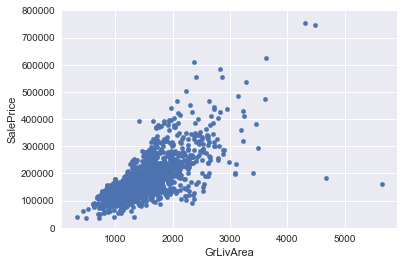

In [19]:
#scatter plot grlivarea/saleprice i.e. square feets vs sale price
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

<p>There are two outliers in the bottom right corner that seem to have undersold too much. Lets find them and remove. We expect to use GrLivArea as strong predictor and do not want the regression to be influented by few outliers.</p>

(1458, 81)


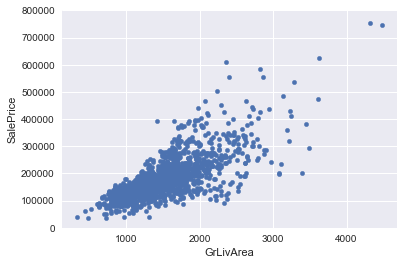

In [20]:
df_train = df_train[(df_train['SalePrice'] > 200000) | (df_train['GrLivArea'] < 4000)]
#We do this later
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));
print(df_train.shape)

This looks much better!


<h1>Manual Encoding</h1>
<p>Some features given as numerical are actually categorical while some other are in the opposite situation.
We make some order</p>
<h3>From Numerical to Categorical</h3>
<p>MSSubClass has numerical values to identify the tybe of dwelling. We need to change this. Similarly MoSold (month Sold)

In [21]:
combine = [df_train, df_competition]
feats = ['MSSubClass', 'MoSold' ]
for df in combine:
    for col in feats:
        df[col+'_str'] = df[col].astype(str)
        df = df.drop(col, axis=1)

<h3>From Categorical to Numerical</h3>
<p>This is less obvious, but some categorical data, addressing for example the quality, holds a numerical meaning, telling that a class is better then another. So we want to manually encode them to keep this information. There are all sort of arbitrairities here, such as the spacing between a class and the following one, nevertheless it seems a more smart approach then just loosing this extra information. </p>
<p>We, moreover, not encode in a one-to-one way, but instead simplify some of the features putting together different, contigous, classes.</p>

In [22]:
Alley_map = {"no-alley" : 0, "Grvl" : 1, "Pave" : 2}

BsmtCond_map = {"no-Bsmnt" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
BsmtExposure_map = {"no-Bsmnt" : 0, "No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4}
BsmtFinType1_map = {"no-Bsmnt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,"ALQ" : 5, "GLQ" : 6}
BsmtFinType2_map = {"no-Bsmnt" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
BsmtQual_map = {"no-Bsmnt" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}

ExterCond_map = {"Po" : 1, "Fa" : 1, "TA": 1, "Gd": 2, "Ex" : 2}
ExterQual_map = {"Po" : 1, "Fa" : 1, "TA": 1, "Gd": 2, "Ex" : 2}
FireplaceQu_map = {"no-fireplace" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 2, "Ex" : 2}
Functional_map = {"Sal" : 1, "Sev" : 1, "Maj2" : 2, "Maj1" : 2, "Mod": 3, "Min2" : 3, "Min1" : 3,\
                  "Typ" : 4}
GarageFinish_map = { "no-garage" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3}
GarageCond_map = {"no-garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
GarageQual_map = {"no-garage" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

HeatingQC_map = {"Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 2, "Ex" : 2}
KitchenQual_map = {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

LandSlope_map = {"Sev" : 1, "Mod" : 2, "Gtl" : 3}
LotShape_map = {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}
PavedDrive_map = {"N" : 1, "P" : 1, "Y" : 2}
PoolQC_map = {"no-pool" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
Street_map = {"Grvl" : 1, "Pave" : 2}
Utilities_map = {"ELO" : 0, "NoSeWa" : 0, "NoSewr" : 1, "AllPub" : 1}

In [23]:
def ListReplace(maps, df):
    for rep in maps:
        df = df.replace(rep)
    return df

combine = [df_train, df_competition]

mappings =  [{"Alley" : Alley_map}, 
                      {"BsmtCond" : BsmtCond_map},
                       {"BsmtExposure" : BsmtExposure_map},
                       {"BsmtFinType1" : BsmtFinType1_map},
                       {"BsmtFinType2" : BsmtFinType2_map},
                       {"BsmtQual" : BsmtQual_map},
                       {"ExterCond" : ExterCond_map},
                       {"FireplaceQu" : FireplaceQu_map},
                       {"Functional" : Functional_map},
                       {"GarageCond" : GarageCond_map},
                       {"GarageQual" : GarageQual_map},
                       {"HeatingQC" : HeatingQC_map},
                       {"KitchenQual" : KitchenQual_map},
                       {"LandSlope" : LandSlope_map},
                       {"PavedDrive" : PavedDrive_map},
                       {"PoolQC" : PoolQC_map},
                       {"Street" : Street_map},
                       {"Utilities" : Utilities_map},
                       {"LotShape" : LotShape_map},
                       {"ExterQual" : ExterQual_map},
                       {'GarageFinish' : GarageFinish_map }]
df_train = ListReplace(mappings, df_train)
df_competition = ListReplace(mappings, df_competition)

In [24]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print("Quantitative features: " + str(len(quantitative)) + "\n" + \
      "Qualitative features: " + str(len(qualitative))  + "\n" +\
     "Total features: " + str(len(df_train.columns) - 2))

Quantitative features: 57
Qualitative features: 23
Total features: 80


<h3>Combine Features</h3>
<p>Some features can be combined to make new ones. Usually we want simple and significant features</p>

In [25]:
def scale(col):
    #not a statistcal scaling but rather a feature normalization for combining them
    return (col - col.min())/(col.max() - col.min())

def FeaturesCombination(df) :
          
    #Basement Baths
    df['BsmtBath'] = df['BsmtFullBath'] + 0.75*df['BsmtHalfBath']
    #Basement Overall Quality scaled by surface
    df['BsmtOvrllQual'] = (1/3)*(scale(df['BsmtQual']) + scale(df['BsmtCond']) +\
                                scale(df['BsmtExposure']))*df['TotalBsmtSF']
    #Basemetn overall Finishing, scaled by surface.
    df['BsmtOvrllFin'] = 0.5*(scale(df['BsmtFinType2'])*df['BsmtFinSF2'] \
                                    + scale(df['BsmtFinType1'])*df['BsmtFinSF1'] )
    df['hasBsmt'] = 0
    df.loc[df['TotalBsmtSF'] > 0, 'hasBsmt'] = 1
    #This four descriptor of the Basement should be sufficient, together with the total SF, and the Quality
    #.We drop the rest
    df = df.drop(['BsmtFullBath', 'BsmtHalfBath', 'BsmtCond',\
                                   'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2',\
                                   'BsmtUnfSF', 'BsmtExposure'], axis=1)

    #Baths
    df['Baths']= df['FullBath'] + 0.75*df['HalfBath']
    df = df.drop(['FullBath', 'HalfBath'], axis=1)

    #Kitchen
    df['KitchenOvrll'] = df['KitchenAbvGr']*scale(df['KitchenQual'])
    df = df.drop(['KitchenQual', 'KitchenAbvGr'], axis=1)

    #garage (we keep Finish (high ANOVA) and GarageCars(high corr with Area, that we drop))
    df['GarageOvrll'] = (1/3)*(scale(df['GarageCond']) + \
                        scale(df['GarageQual']) + scale(df['GarageFinish']))*\
                    (df['GarageArea'])
    df['hasGarage'] = 0
    df.loc[df['GarageCars'] > 0, 'hasGarage'] = 1
    df = df.drop(['GarageQual', 'GarageCond', 'GarageArea'], axis=1)

    #Porch (We keep OpenPorch, as it is most corr with SalePrice)
    df['TotPorchArea'] = (df['EnclosedPorch'] + df['OpenPorchSF'] +\
                                df['3SsnPorch'] + df['ScreenPorch'])
    df = df.drop(['ScreenPorch', '3SsnPorch', 'EnclosedPorch'], axis=1)

    #Pool
    df['PoolOvrll'] = df['PoolArea']*scale(df['PoolQC'])
    df['hasPool'] = 0
    df.loc[df['PoolArea'] >0, 'hasPool'] = 1
    df = df.drop(['PoolQC', 'PoolArea'], axis=1)

    #Fireplaces
    df['FireplacesOvrll'] = df['Fireplaces']*scale(df['FireplaceQu'])
    df['hasFrplc'] = 0
    df.loc[df['Fireplaces'] > 0, 'hasFrplc'] = 1
    df = df.drop(['FireplaceQu', 'Fireplaces'], axis=1)

    #MasVnr
    df['hasMasVnr'] = 0
    df.loc[df['MasVnrArea'] > 0, 'hasMasVnr'] = 1
    
    return df

df_train = FeaturesCombination(df_train)
df_competition = FeaturesCombination(df_competition)

<p>We also reindex everything to make sure that indeces are coherent. Bad indeces (with missing rows ) could be a problem in the next step. </p>

In [26]:
#Clean up some mess with the data indexing
def cleanIndex(df):
    
    #Drop previous index
    df = df.drop('Id', axis=1)
    #Reindexing to take care of dropped lines
    df.reset_index(inplace=True, drop=True)
    df.reset_index(inplace = True)
    return df
df_train = cleanIndex(df_train)
#df_competition = cleanIndex(df_competition)


<h3>Polynomial Features</h3>
<p>We add polynomial (up to degree 2) features for the features most correlated to 'SalePrice'</p>

In [27]:
def AddPoly( df, df_tst, DependentFeat, coeffCut = 0.5, degree = 2):
    corr = df.corr()
    corr.sort_values([DependentFeat], ascending = False, inplace = True)
    features = [f for f in corr.loc[corr[DependentFeat] > coeffCut ].index if f != DependentFeat]
    df_temp = df[features]
    df_temp2 = df_tst[features]
    polys = PolynomialFeatures(degree)
    df_temp = pd.DataFrame(polys.fit_transform(df_temp), columns = polys.get_feature_names(features))
    df_temp2 = pd.DataFrame(polys.transform(df_temp2), columns = polys.get_feature_names(features))
    df_temp = df_temp.drop(features, axis=1)
    df_temp2 = df_temp2.drop(features, axis=1)
    df_temp = pd.concat([df, df_temp], axis=1)
    df_temp2 = pd.concat([df_tst, df_temp2], axis=1)
    return df_temp, df_temp2
df_train, df_competition = AddPoly(df_train, df_competition, 'SalePrice', coeffCut=0.6) 

In [28]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('index')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print("Quantitative features: " + str(len(quantitative)) + "\n" + \
      "Qualitative features: " + str(len(qualitative))  + "\n" +\
     "Total features: " + str(len(df_train.columns) - 2))
print('Datasets Shapes\n Train ' + str(df_train.shape) + \
     '\n Compet. ' + str(df_competition.shape))

Quantitative features: 94
Qualitative features: 23
Total features: 117
Datasets Shapes
 Train (1458, 119)
 Compet. (1459, 118)


<h1>Scaling</h1>

<h2>SalePrice</h2>

Skewness: 1.881296
Kurtosis: 6.523067


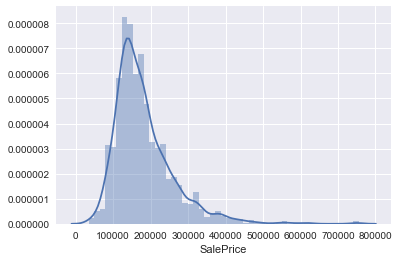

In [29]:
#histogram
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

<p>Positive Skewness means that the "bell" is shifted on the left compared to a normal distribution.
Kurtosis > 3 means more "peaky" then a normal distribution. First of all we scale everything. </p>


Skewness SalePrice: 1.88129648952


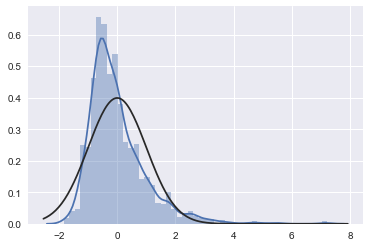

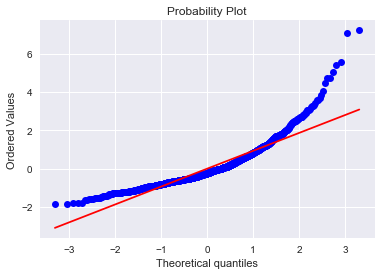

In [30]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
#newaxis adds a dimension: df_train['SalePrice'] is of dimension (n,) while 
                        #df_train['SalePrice'][:,np.newaxis] is (n,1)
    #Standard scaler needs a matrix of dimension (n,d), where n is the number of smaples, and 
    # d is the number of features

#histogram and normal probability plot
sns.distplot(saleprice_scaled[:,0], fit=norm);
fig = plt.figure()
res = stats.probplot(saleprice_scaled[:,0], plot=plt)
print("Skewness SalePrice: " + str(df_train['SalePrice'].skew()))

<p> Second we 'normalize' taking the logarithm. If nothing else, this makes sense in view of the scoring system of the kaggle competition, which take into considaration logs of the sale prices</p>

Skewness LogSalePrice: 0.121568214435
Kurtosis LogSalePrice: 0.804763612901


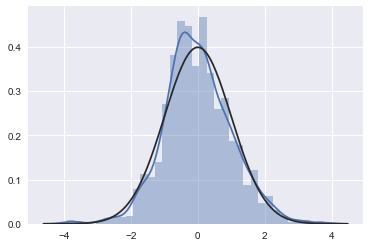

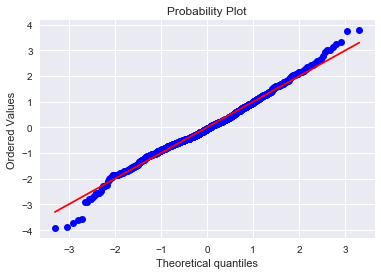

In [31]:
#Lets try some magic (logarithms)
df_train['LogSalePrice'] = np.log(df_train['SalePrice'])
df_train.loc[df_train['LogSalePrice'].isnull()]
logsaleprice_scaled = StandardScaler().fit_transform(df_train['LogSalePrice'][:,np.newaxis])
sns.distplot(logsaleprice_scaled[:,0], fit=norm);
fig = plt.figure()
res = stats.probplot(logsaleprice_scaled[:,0], plot=plt)
print("Skewness LogSalePrice: " + str(df_train['LogSalePrice'].skew()))
print("Kurtosis LogSalePrice: " + str(df_train['LogSalePrice'].kurtosis()))

<p>LogSalePrice is much less skewed and looks, much more like a normal</p>

<h3>Log everything that is skewed!</h3>
<p>We decide that having skewness greater then 1 is a sign of too much skewness, to be corrected with a log. Way arbitrary, but it is not going to be harmful anyway and should reduce the impact of outliers. (Usually one should avoid negative numbers uinside logarithms, however here the data are non negative so log1p(x) = log(1 + x) is gauranteed strictly postive)</p>
<p>Negatively skewed data need a reflection before applying the log1p.</p>

In [32]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('index')
quantitative.remove('LogSalePrice')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print("Quantitative features: " + str(len(quantitative)) + "\n" + \
      "Qualitative features: " + str(len(qualitative))  + "\n" +\
     "Total features: " + str(len(df_train.columns) - 3))

Quantitative features: 94
Qualitative features: 23
Total features: 117


In [33]:
skewness = df_train[quantitative].apply(lambda  x : skew(x))
Neg_skewness = skewness[skewness < -1]
Pos_skewness = skewness[skewness > 1]
for f in Pos_skewness.index :
    df_train["(" + f + ")" + "_Log1p"] = np.log1p(df_train[f]) 
    df_train = df_train.drop(f, axis=1)
    df_competition["(" + f + ")" + "_Log1p"] = np.log1p(df_competition[f]) 
    df_competition = df_competition.drop(f, axis=1)

In [34]:
for f in Neg_skewness.index :
    df_train["(" + f + ")" + "_Log1p"] = np.log1p(df_train[f].max() - df_train[f]) 
    df_train = df_train.drop(f, axis=1)
    df_competition["(" + f + ")" + "_Log1p"] = np.log1p(df_competition[f].max() - df_competition[f]) 
    df_competition = df_competition.drop(f, axis=1)

<h1>Pre-Processing</h1>
<p>Ok, then. Our data is ready to be formally preprocessed!</p>

In [35]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('index')
quantitative.remove('LogSalePrice')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
print("Quantitative features: " + str(len(quantitative)) + "\n" + \
      "Qualitative features: " + str(len(qualitative))  + "\n" +\
     "Total features: " + str(len(df_train.columns) - 3))

Quantitative features: 94
Qualitative features: 23
Total features: 117


<h2> Qualitative</h2> 
<p>We use the p-values of an Analysis of Variance on the qualitative variables to have a quick and dirty
understanding of the influence of such features on the SalePrice.</p>
<p>ANOVA is just a linear regression for qualitative feature, where each class of the feature becomes a distinct independent variable. The p-values refer to the hypthesis test that the avarages of the dependent values in each classes is the same. Then, small p-values means that we can reject such hypohthesis with more confidence. It doesn't say anything about accepting the opposite hypothesis thought. Nevertheless it can be used to have an idea of such features that may be more promising in distinguish price ranges</p>
<p>We can expect Neighbourhood to be an important feature</p>


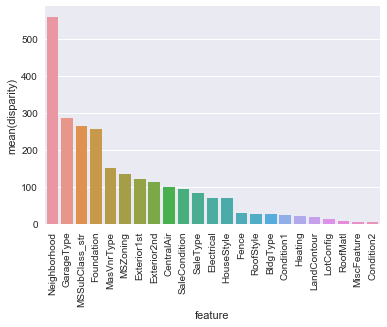

In [36]:
def anova(df, features, dependentFeat ):
    anv = pd.DataFrame()
    anv['feature'] = features
    pvals = []
    for c in features:
        samples = []
        for cls in df[c].unique():
            #cls varies among the unique values attainable by the Feature c (i.e classes)
            s = df[df[c] == cls][dependentFeat].values
            #so s are such samples of SalePrice with feature c = to value cls
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        #f_oneway (one way ANOVA) tests the hypothesis H_0: all the samples come from populations with
        #same mean. pval stores the p value of the hypothesy test. 
        #so it indicates the wrost chance of a wrong reject. i.e. Small p-value means good chances
        # there is significant difference in the mean of different samples
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df_train, qualitative, 'LogSalePrice')
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)


<h3>Qualitative encoding</h3>

In [37]:
print(df_train.shape + df_competition.shape)

(1458, 120, 1459, 118)


In [38]:
def EncodeQuals(df, features) :
    for f in features :
        df_f = pd.get_dummies(df[f], prefix=f)
        for c in df_f.columns :
            df[c] = df_f[c]
        df = df.drop(f, axis =1)
    return df

df_train = EncodeQuals(df_train, qualitative)
df_competition = EncodeQuals(df_competition, qualitative)
print(df_train.shape + df_competition.shape)

(1458, 280, 1459, 265)


<p>We need to fix the absence of some feature in the competition data_set after the get_dummies is called. This is due to the absence in the second dataset of some value type in some qualitative variable</p>

In [39]:
TotCols = df_train.drop(['index', 'SalePrice', 'LogSalePrice'], axis=1).columns
GotCols = df_competition.drop(['Id'], axis=1).columns
missingFeats = list(set(TotCols) - set(GotCols))
extraFeats = list(set(GotCols) - set(TotCols) )
print('Missing Features in Competition DataSet: ' + str(missingFeats))
print('Extra Features in Competition DataSet: ' + str(extraFeats))
for f in missingFeats :
    df_competition[f] = 0
for f in extraFeats :
    df_train[f] = 0
print(df_train.shape + df_competition.shape)

Missing Features in Competition DataSet: ['Condition2_RRNn', 'Heating_OthW', 'RoofMatl_Roll', 'Condition2_RRAn', 'RoofMatl_Metal', 'Exterior1st_ImStucc', 'Electrical_Mix', 'Exterior1st_Stone', 'RoofMatl_Membran', 'MiscFeature_TenC', 'Condition2_RRAe', 'HouseStyle_2.5Fin', 'Exterior2nd_Other', 'Heating_Floor']
Extra Features in Competition DataSet: ['MSSubClass_str_150']
(1458, 281, 1459, 279)


<h3>Data Splitting</h3>
<p>Not all data is used for the same reason. Some will be used for training, some for testing the models</p>

In [40]:
X_all = df_train.drop(['index', 'SalePrice', 'LogSalePrice'], axis=1)
y_all = df_train['LogSalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all , test_size = 0.2, random_state = 27)
#Nullity checks
print(str(X_train.isnull().values.sum()) + ", " + str(X_test.isnull().values.sum()))
print(str(y_train.isnull().values.sum()) + ", " + str(y_test.isnull().values.sum()))

0, 0
0, 0


In [41]:
X_comp = df_competition.drop(['Id'], axis=1)
#Nullity checks
print(str(X_comp.isnull().values.sum()))

0


<p>Quantitative data should be scaled in order to have mean 0 and standard deviation 1. This is a requirementd of many regression algorithms.</p>

In [42]:
scaler = StandardScaler()
X_train[quantitative] = scaler.fit_transform(X_train[quantitative])
X_test[quantitative] = scaler.transform(X_test[quantitative])
#X_comp[quantitative] = scaler.transform(X_comp[quantitative])

<p>The official scoring is the Root Mean Squared Error (RMSE) of the logPrices. It is also a natural one for this kind of problem. So we use the same to evaluate our models.</p>

In [43]:
scorer = make_scorer(mean_squared_error)

<p>We also need a cross validation routine, that uses the scorer to compute a cross validation error. </p>

In [44]:
def rmse_cv(model, scoring, X, y, CV=5):
    rmse= np.sqrt(cross_val_score(estimator=model, X=X, y=y, scoring=scoring, cv=CV))
    return(rmse)


We will use the following function modelOverview to have a graphical visulaization of the models

In [45]:
def modelOverview(model, X_train, y_train, X_test, y_test, coef = 'coef') :
    model.fit(X_train, y_train)
    print("Model score on test-set: " + str( model.score(X=X_test, y=y_test)))
    y_test_pred = model.predict(X=X_test)
    y_train_pred = model.predict(X=X_train)
    RMSE_score = np.sqrt(mean_squared_error(y_pred=y_test_pred, y_true=y_test))
    print("Model RMSE on test-set: " + str(RMSE_score))

    # Plot residuals
    plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Residuals Plot")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

    # Plot predictions
    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Discripencies of Predictions")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

    # Plot important coefficients
    if(coef == 'coef') :
        coefs = pd.Series(model.coef_, index = X_train.columns)
    elif(coef == 'feature_importances') :
         coefs = pd.Series(model.feature_importances_, index = X_train.columns)
    elif(coef == 'none') : 
        return RMSE_score
    else :
        print('Invalid coef input')
        return RMSE_score
    print("The Model picked " + str(sum(coefs >= 1e-6)) + " features and eliminated the other " +  \
          str(sum(coefs < 1e-6)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    plt.title("Coefficients in the Model")
    plt.show()
    return RMSE_score

Models_scoring = pd.DataFrame()


<h3>Ridge Linear Regression</h3>
<p>Ridge model is a linear regression with regularization proportional to the Euclidean norm of the parameter vector. In order to chose the best proportionality constant (alpha) we use cross validation inside the X_train data subset.</p>

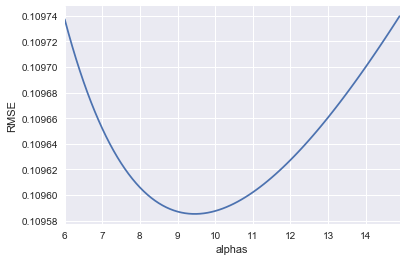

In [46]:
alphas = np.arange(6, 15, 0.1)
ridge_rmse = [ rmse_cv(Ridge(alpha=this_alpha),scoring=scorer,X=X_train, y=y_train).mean() for this_alpha in alphas]
ridge_rmse= pd.Series(ridge_rmse, index=alphas)
ridge_rmse.plot()
plt.xlabel("alphas")
plt.ylabel("RMSE")

Best alpha: 9.5, with train RMSE0.109585244544
Model score on test-set: 0.911459375758
Model RMSE on test-set: 0.110400714407


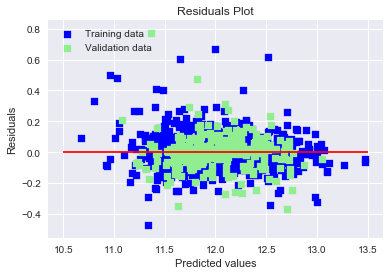

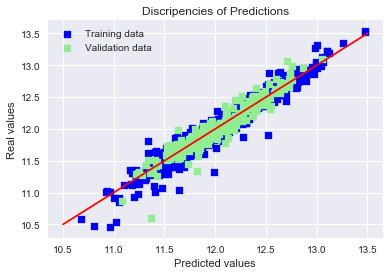

The Model picked 135 features and eliminated the other 143 features


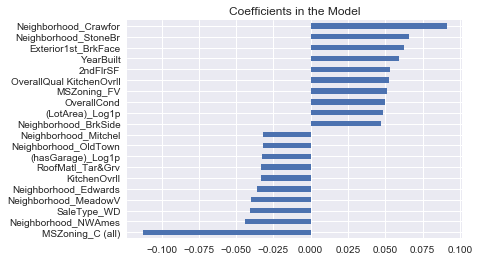

In [47]:
The_alpha  = ridge_rmse.loc[ridge_rmse == ridge_rmse.min()].index[0]
print("Best alpha: " + str(The_alpha) + ", with train RMSE" + str(ridge_rmse.min()))

model_ridge = Ridge(alpha=The_alpha)
Models_scoring['Ridge'] = [modelOverview(model=model_ridge, X_test=X_test, X_train=X_train, y_test=y_test,\
              y_train=y_train, coef='coef')]

<h3>Lasso linear Regrassion</h3>
<p>Lasso linear regression is a standard linear regression with regolarization factor proportional to 1-norm of the parameters vector. For such reason it tends to give a more sparse feature selection. We again need to find the proportionality constant of the regularization via Cross Validation</p>

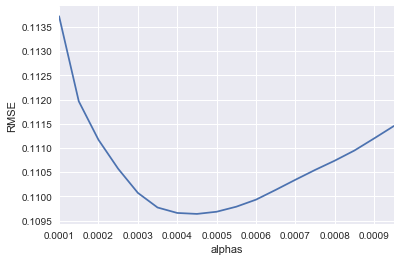

In [48]:
alphas = np.arange(0.0001, 0.001, 0.00005)
lasso_rmse = [ rmse_cv(Lasso(alpha=this_alpha),scoring=scorer,X=X_train, y=y_train).mean() for this_alpha in alphas]
lasso_rmse= pd.Series(lasso_rmse, index=alphas)
lasso_rmse.plot()
plt.xlabel("alphas")
plt.ylabel("RMSE")

Best alpha: 0.00045, with train RMSE0.109637521644
Model score on test-set: 0.91389889606
Model RMSE on test-set: 0.108869180501


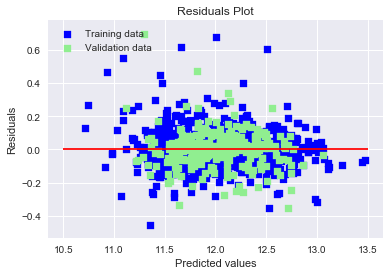

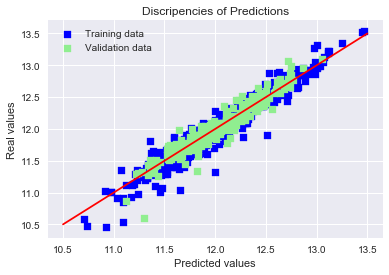

The Model picked 56 features and eliminated the other 222 features


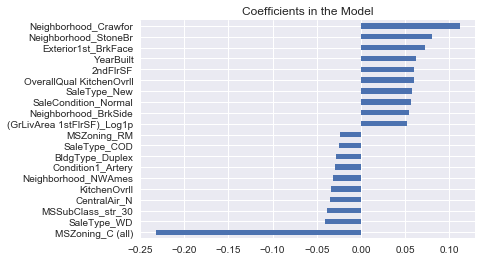

In [49]:
The_alpha  = lasso_rmse.loc[lasso_rmse == lasso_rmse.min()].index[0]
print("Best alpha: " + str(The_alpha) + ", with train RMSE" + str(lasso_rmse.min()))

model_lasso = Lasso(alpha=The_alpha)
Models_scoring['Lasso'] = [modelOverview(model=model_lasso, X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train, coef='coef')]

<h3>Elastic Net</h3>
<p>Elastic net are linear model with regularization made of two component, one proportional to the euclidean norm of the feature's coefficients, and the other proportional to the l1 norm.</p>

In [50]:
model_elastic = ElasticNetCV(l1_ratio =  np.arange(0.7, 1.01, 0.01),
                          alphas = np.arange(0.0003, 0.0005, 0.00001), 
                          max_iter = 50000, cv = 10)
model_elastic.fit(X_train, y_train)
print("Best parameters for Elastic net : alpha = " + str(model_elastic.alpha_) +\
         ", l1_ratio = " + str(model_elastic.l1_ratio_))

Best parameters for Elastic net : alpha = 0.00042, l1_ratio = 1.0


Model score on test-set: 0.913992011967
Model RMSE on test-set: 0.108810295107


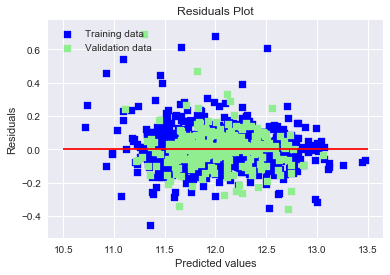

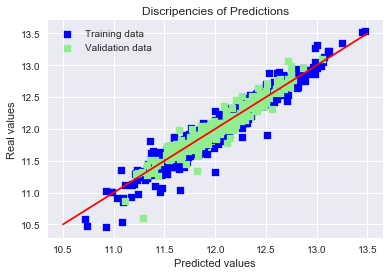

The Model picked 59 features and eliminated the other 219 features


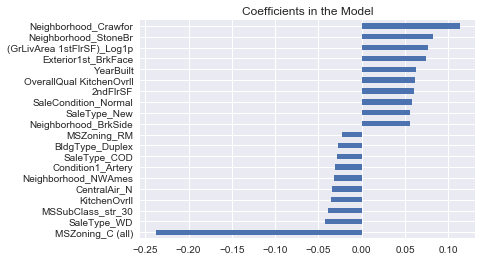

In [51]:
Models_scoring['Elastic_net'] = [modelOverview(model=model_elastic, X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train, coef='coef')]

<h3>Random Forest Regressor </h3>


In [52]:
model_RF= RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [100], 
              'max_features': ['sqrt', 'log2', 0.5], 
              'criterion': ['mse'],
              'max_depth': [None], 
              'min_samples_split': [2, 3, 5, 0.01],
              'min_samples_leaf': [1,0.01, 0.005]
             }



# Run the grid search
grid_obj = GridSearchCV(model_RF, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
model_RF = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
model_RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=0.01,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Cross validation gave the following setting 
```python
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=0.01,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
```

Model score on test-set: 0.852433265774
Model RMSE on test-set: 0.14252623963


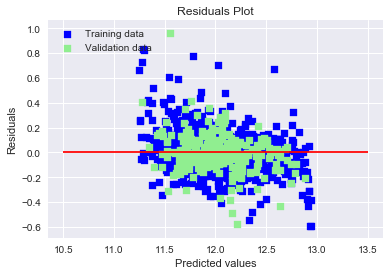

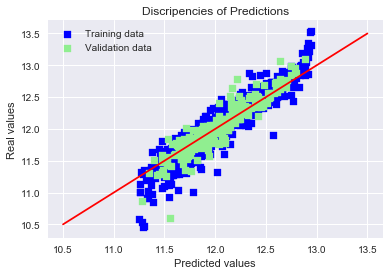

The Model picked 152 features and eliminated the other 126 features


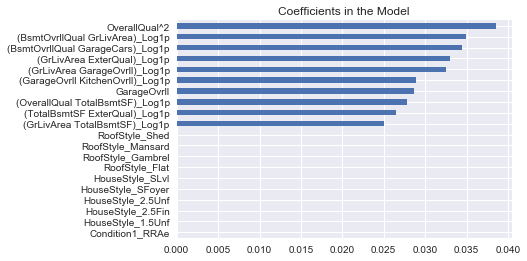

In [53]:
Models_scoring['Random_forest'] = [modelOverview(model=model_RF, X_test=X_test, X_train=X_train, y_test=y_test,\
              y_train=y_train, coef = 'feature_importances')]

<h3>Simple Nerual Network</h3>


In [54]:
model_MLP = MLPRegressor()

# Choose some parameter combinations to try
parameters = { 'solver' : ['adam'],
              'hidden_layer_sizes': [[200, 200, 200], [200,200], [300, 200]], 
              'alpha': [ 0.01, 0.05, 0.1], 
              'activation' : [ 'tanh', 'relu', 'logistic', 'identity']
             }



# Run the grid search
grid_obj = GridSearchCV(model_MLP, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
model_MLP = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
model_MLP.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[200, 200], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Model score on test-set: 0.69116917349
Model RMSE on test-set: 0.206186827223


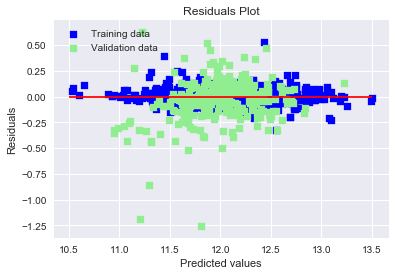

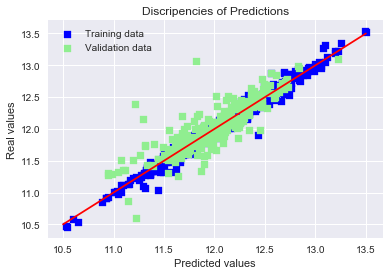

In [55]:
Models_scoring['MLP_regressor'] = [modelOverview(model=model_MLP, X_test=X_test, X_train=X_train, y_test=y_test,\
              y_train=y_train, coef = 'none')]

<h3>Ensambling</h3>
<p>Now we try to put together different models to get a better one</p>

In [56]:
#train
X_ens = pd.DataFrame()
X_ens['Ridge'] = model_ridge.predict(X_train)
X_ens['Lasso'] = model_lasso.predict(X_train)
X_ens['ElasticNet'] = model_elastic.predict(X_train)
X_ens['RF'] = model_RF.predict(X_train)
X_ens['MLP'] = model_MLP.predict(X_train)

#test
X_ens_test = pd.DataFrame()
X_ens_test['Ridge'] = model_ridge.predict(X_test)
X_ens_test['Lasso'] = model_lasso.predict(X_test)
X_ens_test['ElasticNet'] = model_elastic.predict(X_test)
X_ens_test['RF'] = model_RF.predict(X_test)
X_ens_test['MLP'] = model_MLP.predict(X_test)
X_ens.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
Ridge         1166 non-null float64
Lasso         1166 non-null float64
ElasticNet    1166 non-null float64
RF            1166 non-null float64
MLP           1166 non-null float64
dtypes: float64(5)
memory usage: 45.6 KB


In [57]:
scaler = StandardScaler()
X_ens[X_ens.columns] = scaler.fit_transform(X_ens[X_ens.columns])
X_ens_test[X_ens_test.columns] = scaler.transform(X_ens_test[X_ens_test.columns])


In [58]:
#ensambling with random forest

model_RF_ens = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [300], 
              'max_features': [ 0.5, 'auto'], 
              'criterion': ['mse'],
              'max_depth': [None], 
              'min_samples_split': [2],
              'min_samples_leaf': [ 0.0001, 0.00005]
             }



# Run the grid search
grid_obj = GridSearchCV(model_RF_ens, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_ens, y_train)

# Set the clf to the best combination of parameters
model_RF_ens = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
model_RF_ens.fit(X_ens, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5e-05, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Model score on test-set: 0.817430116454
Model RMSE on test-set: 0.158531351925


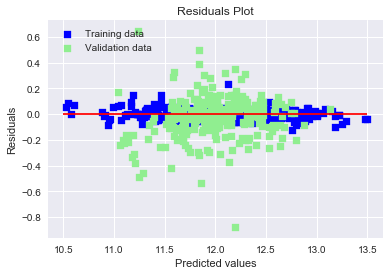

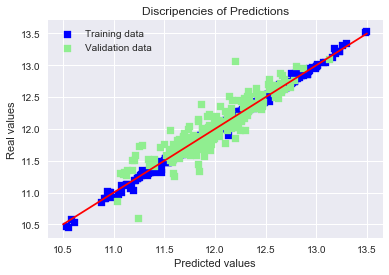

The Model picked 5 features and eliminated the other 0 features


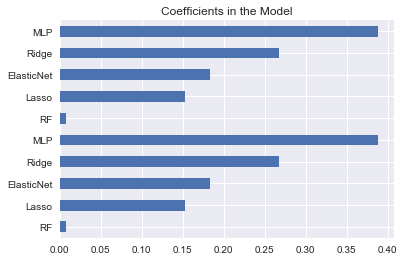

In [59]:
Models_scoring['Ensamble_RF'] =[modelOverview(model=model_RF_ens, X_test=X_ens_test, X_train=X_ens, y_test=y_test,\
              y_train=y_train, coef='feature_importances')]

In [60]:
#ensambling with MLP

model_MLP_ens = MLPRegressor()

# Choose some parameter combinations to try
parameters = { 'solver' : ['adam'],
              'hidden_layer_sizes': [ [200, 200, 200], [200, 200], [300, 300,300]], 
              'alpha': [0.0001, 0.001, 0.01], 
              'activation' : [ 'tanh', 'logistic', 'relu', 'identity']
             }



# Run the grid search
grid_obj = GridSearchCV(model_MLP_ens, parameters, scoring=scorer)
grid_obj = grid_obj.fit(X_ens, y_train)

# Set the clf to the best combination of parameters
model_MLP_ens = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
model_MLP_ens.fit(X_ens, y_train)

MLPRegressor(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[200, 200, 200], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Model score on test-set: 0.564787951817
Model RMSE on test-set: 0.244765976421


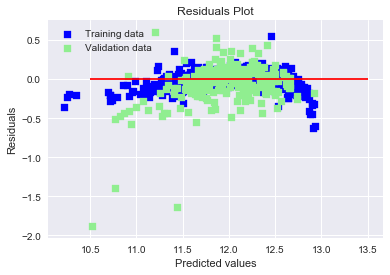

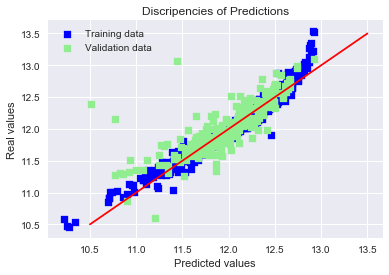

In [61]:
Models_scoring['Ensable_MLP'] = [modelOverview(model=model_MLP_ens, X_test=X_ens_test, X_train=X_ens, y_test=y_test,\
              y_train=y_train, coef = 'none')]

In [62]:
#ensamble with elastic net
model_elastic_ens = ElasticNetCV(l1_ratio =  np.arange(0.1, 1.01, 0.1),
                          alphas = np.arange(0.000001, 0.0001, 0.000003), 
                          max_iter = 50000, cv = 10)
model_elastic_ens.fit(X_ens, y_train)
print("Best parameters for Elastic net : alpha = " + str(model_elastic.alpha_) +\
         ", l1_ratio = " + str(model_elastic.l1_ratio_))

Best parameters for Elastic net : alpha = 0.00042, l1_ratio = 1.0


Model score on test-set: 0.70449973523
Model RMSE on test-set: 0.201687754668


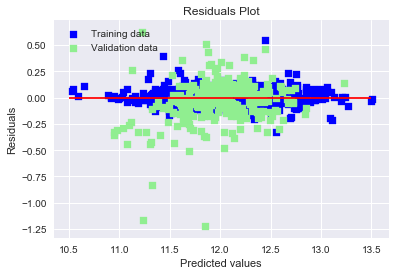

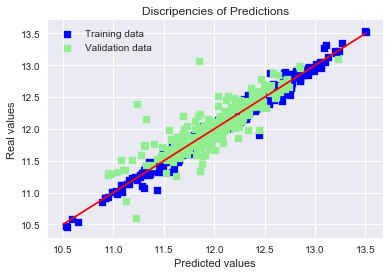

The Model picked 3 features and eliminated the other 2 features


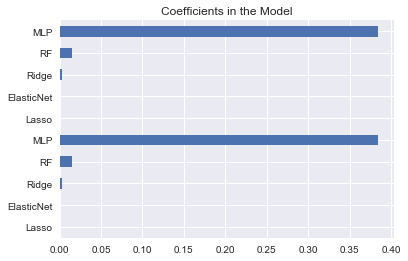

In [63]:
Models_scoring['Ensamble_EN'] = [modelOverview(model=model_elastic_ens, X_test=X_ens_test, X_train=X_ens, y_test=y_test, y_train=y_train)]

In [64]:
Scores = pd.DataFrame()
Scores['Model'] = Models_scoring.columns
Scores['Score'] = Models_scoring.loc[0].values
print('RSME score of different models, lowest is better')
Scores.sort_values(ascending=True, by='Score')

RSME score of different models, lowest is better


,Model,Score
2,Elastic_net,0.108810
1,Lasso,0.108869
0,Ridge,0.110401
3,Random_forest,0.142526
5,Ensamble_RF,0.158531
7,Ensamble_EN,0.201688
4,MLP_regressor,0.206187
6,Ensable_MLP,0.244766


<h2>Competition Results</h2>
<p>Before we compute the result for the competition dataset with every model, we need to retrain the models with the whole training dataset. We drop the ensamble MLP model as it has the worst score in the training set.</p>

In [65]:
#Rescale X_all

scaler_basics = StandardScaler()
X_all[quantitative] = scaler_basics.fit_transform(X_all[quantitative])
X_comp[quantitative]= scaler_basics.transform(X_comp[quantitative])

#Retrain Basic models
model_ridge.fit(X_all, y_all)
model_lasso.fit(X_all, y_all)
model_elastic.fit(X_all, y_all)
model_RF.fit(X_all, y_all)
model_MLP.fit(X_all, y_all)


MLPRegressor(activation='tanh', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[200, 200], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [66]:
#Retrain Ensamble Models

X_ens_all = pd.DataFrame()
X_ens_all['Ridge'] = model_ridge.predict(X_all)
X_ens_all['Lasso'] = model_lasso.predict(X_all)
X_ens_all['ElasticNet'] = model_elastic.predict(X_all)
X_ens_all['RF'] = model_RF.predict(X_all)
X_ens_all['MLP'] = model_MLP.predict(X_all)

scaler_ens = StandardScaler()
X_ens_all[X_ens_all.columns] = scaler_ens.fit_transform(X_ens_all[X_ens_all.columns])


model_RF_ens.fit(X_ens_all, y_all)
model_elastic_ens.fit(X_ens_all, y_all)

ElasticNetCV(alphas=array([  1.00000e-06,   4.00000e-06,   7.00000e-06,   1.00000e-05,
         1.30000e-05,   1.60000e-05,   1.90000e-05,   2.20000e-05,
         2.50000e-05,   2.80000e-05,   3.10000e-05,   3.40000e-05,
         3.70000e-05,   4.00000e-05,   4.30000e-05,   4.60000e-05,
         4.90000e-05,   5...20000e-05,
         8.50000e-05,   8.80000e-05,   9.10000e-05,   9.40000e-05,
         9.70000e-05]),
       copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
       max_iter=50000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

<p>Next we make predictions with the basic models, on the competition Dataset</p>

In [67]:
#prediction
X_ens_comp = pd.DataFrame()
X_ens_comp['Ridge'] = model_ridge.predict(X_comp)
X_ens_comp['Lasso'] = model_lasso.predict(X_comp)
X_ens_comp['ElasticNet'] = model_elastic.predict(X_comp)
X_ens_comp['RF'] = model_RF.predict(X_comp)
X_ens_comp['MLP'] = model_MLP.predict(X_comp)

y_ridge = np.exp(X_ens_comp['Ridge'])
y_lasso = np.exp(X_ens_comp['Lasso'])
y_elastic = np.exp(X_ens_comp['ElasticNet'])
y_RF = np.exp(X_ens_comp['RF'])
y_MLP = np.exp(X_ens_comp['MLP'])


#submissions Dataset
Indeces = df_competition['Id']

sub_ridge = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_ridge })
sub_lasso = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_lasso })
sub_elastic = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_elastic })
sub_RF = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_RF })
sub_MLP = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_MLP })

#submission Files
sub_ridge.to_csv("RidgeSub.csv", index=False)
sub_lasso.to_csv("lassoSub.csv", index=False)
sub_elastic.to_csv("elasticSub.csv", index=False)
sub_RF.to_csv("RFSub.csv", index=False)
sub_MLP.to_csv("MLPSub.csv", index=False)

In [68]:
#Scale ensble competition dataset 
X_ens_comp[X_ens_comp.columns] = scaler_ens.transform(X_ens_comp[X_ens_comp.columns])

#Prediction datasets
y_RF_ens = np.exp(model_RF_ens.predict(X_ens_comp))
y_elastic_ens = np.exp(model_elastic_ens.predict(X_ens_comp))

sub_RF_ens = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_RF_ens })
sub_elastic_ens = pd.DataFrame({ 'Id': Indeces,
                            'SalePrice': y_elastic_ens })

#Prediction files
sub_RF_ens.to_csv("RF_ensSub.csv", index=False)
sub_elastic_ens.to_csv("elastic_ensSub.csv", index=False)

<p>In general, both on test sets and in the competitions, ensambled models perform extremely poorly compared to lasso or Elastic Net</p>